In [ ]:
pip install d2l==1.0.0b0

In [3]:
import torch
from torch import nn
from d2l import torch as d2l
from torch import tensor
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from torch.nn import functional as F

from tensorflow import keras 
from keras.datasets import cifar10 
import matplotlib.pyplot as plt 

In [4]:
class Cifar10(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(64, 64)):
        super().__init__()
        self.save_hyperparameters()
        transform = transforms.Compose(
        [transforms.ToTensor()])
        
        self.train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
        self.val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=transform)
        
                                                
    def text_labels(self, indices):
        labels = ['plane', 'car', 'bird', 'cat',
                  'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=2)

In [5]:
class Module(d2l.nn_Module, d2l.HyperParameters):
    def __init__(self, plot_train_per_epoch=3, plot_valid_per_epoch=2):
        super().__init__()
        self.save_hyperparameters()
        self.board = d2l.ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

In [13]:
class Classifier(Module):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=True)

    def accuracy(self, Y_hat, Y, averaged=True):
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
        compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
        return d2l.reduce_mean(compare) if averaged else compare
        

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return d2l.F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

#**Problem 1: Baseline model for VGG**

In [14]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [15]:
class VGG(Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(init_cnn)


In [16]:
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)


In [17]:
VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


VGG(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(ker

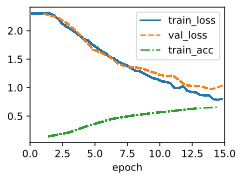

In [18]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.075)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
data = Cifar10(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [19]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))

VGG(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): LazyConv2d(0, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(

#VGG-19

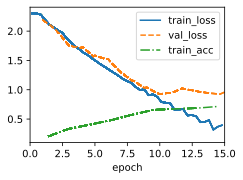

In [20]:
model = VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)), lr=0.075)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
data = Cifar10(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

# **Problem 2: Baseline model for GoogleNet**

In [21]:
class Inception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [22]:
class GoogleNet(Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def b3(self):
        return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def b4(self):
        return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
            Inception(160, (112, 224), (24, 64), 64),
            Inception(128, (128, 256), (24, 64), 64),
            Inception(112, (144, 288), (32, 64), 64),
            Inception(256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def b5(self):
      return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
      
    def __init__(self, lr=0.1, num_classes=10):
        super(GoogleNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                              self.b5(), nn.LazyLinear(num_classes))
        self.net.apply(init_cnn)

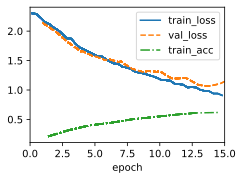

In [23]:
model = GoogleNet(lr=0.1)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
data = Cifar10(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

#Adding batch normailzation to the CIFAR-10 data set for GoogleNet

In [24]:
class Cifar10_batch_norm(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(64, 64)):
        super().__init__()
        self.save_hyperparameters()
        transform = transforms.Compose(
        [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        self.train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
        self.val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=transform)
        
                                                
    def text_labels(self, indices):
        labels = ['plane', 'car', 'bird', 'cat',
                  'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=2)

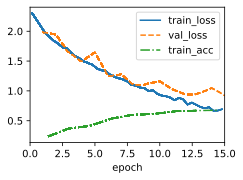

In [25]:
model = GoogleNet(lr=0.1)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
data = Cifar10_batch_norm(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

#**Problem 3: ResNet**

In [52]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [53]:
class ResNet(Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)
        
    def __init__(self, arch, lr=0.1, num_classes=10):
        super(ResNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(init_cnn)

In [54]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

#ResNet-18

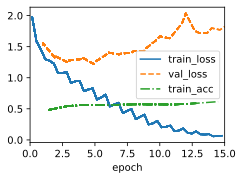

In [55]:
model = ResNet18(lr=0.005)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
data = Cifar10(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

#ResNet-26

In [56]:
class ResNet26(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (3, 128), (4, 256), (2, 512)),
                       lr, num_classes)

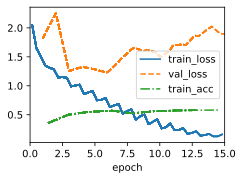

In [57]:
model = ResNet26(lr=0.005)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
data = Cifar10(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

#ResNet-32

In [58]:
class ResNet32(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((3, 64), (4, 128), (6, 256), (3, 512)),
                       lr, num_classes)

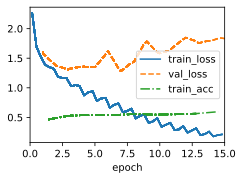

In [59]:
model = ResNet32(lr=0.005)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
data = Cifar10(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

#DenseNet comparison to ResNet

In [60]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [61]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [62]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [63]:
class DenseNet(Classifier):
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
              lr=0.1, num_classes=10):
      super(DenseNet, self).__init__()
      self.save_hyperparameters()
      self.net = nn.Sequential(self.b1())
      for i, num_convs in enumerate(arch):
          self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
          num_channels += num_convs * growth_rate
          if i != len(arch) - 1:
              num_channels //= 2
              self.net.add_module(f'tran_blk{i+1}', transition_block(
                  num_channels))
      self.net.add_module('last', nn.Sequential(
          nn.LazyBatchNorm2d(), nn.ReLU(),
          nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
          nn.LazyLinear(num_classes)))
      self.net.apply(d2l.init_cnn)
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

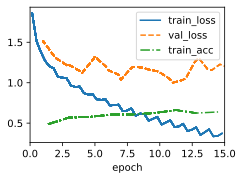

In [64]:
model = DenseNet(lr=0.005)
trainer = d2l.Trainer(max_epochs=15, num_gpus=1)
data = Cifar10(batch_size=128, resize=(96, 96))
trainer.fit(model, data)